[Reference](https://medium.com/@codewithmuse/41ffb7090a38)

In [1]:
!pip install polars yfinance duckdb pyarrow matplotlib

In [2]:
!python --version

Python 3.12.11


# Step 1: Fetch Stock Data

In [3]:
import polars as pl
import yfinance as yf
import duckdb
import matplotlib.pyplot as plt

In [4]:
prices = yf.download("NVDA", start="2024-01-01", end="2025-01-01")


/tmp/ipython-input-1125674547.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download("NVDA", start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [5]:
df = pl.from_pandas(prices.reset_index()).with_columns(
    pl.lit("NVDA").alias("symbol")
)

In [6]:
try:
    prices = yf.download("NVDA", start="2024-01-01", end="2025-01-01")
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

/tmp/ipython-input-638701509.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download("NVDA", start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [7]:
prices

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2024-01-02,48.146572,49.273070,47.573829,49.222094,411254000
2024-01-03,47.547840,48.162564,47.298950,47.463878,320896000
2024-01-04,47.976650,48.478426,47.486867,47.745750,306535000
2024-01-05,49.075157,49.524958,48.284509,48.440441,415039000
2024-01-08,52.229755,52.251749,49.456991,49.489977,642510000
...,...,...,...,...,...
2024-12-24,140.197372,141.877094,138.627618,139.977407,105157000
2024-12-26,139.907410,140.827275,137.707768,139.677451,116205600


# Step 2: Create the DuckDB Database

In [8]:
con = duckdb.connect("stocks.db")

In [9]:
con.execute("""
    CREATE TABLE IF NOT EXISTS stocks AS SELECT * FROM df
""")

In [10]:
row_count = con.execute("SELECT COUNT(*) FROM stocks").fetchone()
print(f"Rows in table: {row_count[0]}")

Rows in table: 252


# Step 3: Query Insights with SQL

## Average Closing Price

In [11]:
avg_close = con.execute(f"""
    SELECT symbol, ROUND(AVG("('Close', 'NVDA')"), 2) AS avg_close
    FROM stocks
    GROUP BY symbol
""").fetchdf()
print(avg_close)

  symbol  avg_close
0   NVDA     107.79


## Top 5 Volume Days


In [12]:
high_vol = con.execute(f"""
    SELECT symbol, "('Date', '')", "('Volume', 'NVDA')", "('Close', 'NVDA')"
    FROM stocks
    ORDER BY "('Volume', 'NVDA')" DESC
    LIMIT 5
""").fetchdf()
print(high_vol)

  symbol ('Date', '')  ('Volume', 'NVDA')  ('Close', 'NVDA')
0   NVDA   2024-03-08          1142269000          87.493172
1   NVDA   2024-04-19           875198000          76.169685
2   NVDA   2024-02-22           865100000          78.503075
3   NVDA   2024-05-23           835065000         103.757698
4   NVDA   2024-02-23           829388000          78.781944


## Rolling 20-Day VWAP

In [13]:
vwap_query = """
    WITH daily_vwap AS (
        SELECT
            "('Date', '')",
            symbol,
            SUM("('Volume', 'NVDA')" * "('Close', 'NVDA')") / SUM("('Volume', 'NVDA')") AS vwap
        FROM stocks
        GROUP BY "('Date', '')", symbol
    ),
    rolling_vwap AS (
        SELECT
            "('Date', '')",
            symbol,
            AVG(vwap) OVER (
                PARTITION BY symbol
                ORDER BY "('Date', '')"
                ROWS BETWEEN 19 PRECEDING AND CURRENT ROW
            ) AS rolling_20d_vwap
        FROM daily_vwap
    )
    SELECT * FROM rolling_vwap
    ORDER BY symbol, "('Date', '')";
"""

In [14]:
vwap_df = pl.DataFrame(con.execute(vwap_query).fetchdf())
vwap_df = vwap_df.rename({
    "('Date', '')": "Date"
})

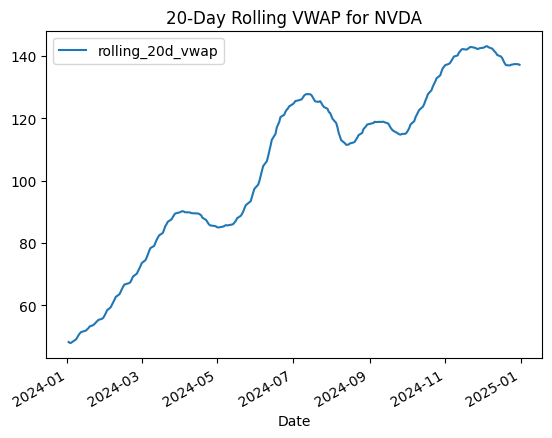

In [15]:
vwap_df.to_pandas().plot(x="Date", y="rolling_20d_vwap", title="20-Day Rolling VWAP for NVDA")
plt.show()

# Step 4: Expand the Database


In [16]:
symbols = ["NVDA", "AAPL", "TSLA"]

for sym in symbols:
    prices = yf.download(sym, start="2024-01-01", end="2025-01-01")
    df = pl.from_pandas(prices.reset_index()).with_columns(pl.lit(sym).alias("symbol"))
    con.execute("INSERT INTO stocks SELECT * FROM df")

/tmp/ipython-input-3401909990.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(sym, start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3401909990.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(sym, start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3401909990.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(sym, start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
